# EECS 491 - Probabilistic Graphical Models Assignment 5
**David Fan**

4/25/18

In this notebook we will attempt to use Independent Component Analysis (ICA) to blindly separate $n$ mixed sources of audio. In the common problem, there are $n$ separate sound sources and $n$ different microphones recording sound at different positions in the room. We then try to figure out what each sound source is using all of the mixed sources. We will assume the sound sources follow a specific prior distribution, and we use likelihood maximization to optimize the mixing matrix.

## Load Audio Files

In [1]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')
_, dataSpeech = wavfile.read('data/speech.wav')

Next we normalize our audiofiles into the range of $[-0.5, 0.5]$.

In [2]:
import numpy as np

def audionorm(data):
    data = np.asarray(data).astype('float')
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    return data

In [3]:
gtruthS = audionorm([dataBach, dataSpeech])

## Audio Mixer
We're going to borrow the simple audio mixer that was created in the demo to compose our mixed sound tracks.

In [4]:
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

As well as the plotting function...

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')

Now we can create our mixed sound tracks with the ground truth mixing matrix and plot it.

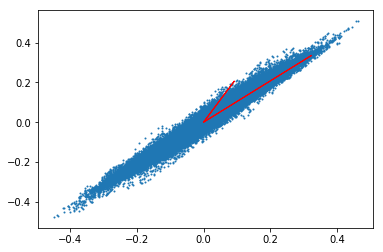

In [6]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

Now we write our mixed sound tracks into files so we can play them through an audio player.

In [7]:
wavfile.write('data/mixedTrackA.wav', srate, X[0])
wavfile.write('data/mixedTrackB.wav', srate, X[1])

## A Bit of Quick Background
Let's quickly discuss what the mixing matrix is and the theory behind using the mixing matrix to recover our sound sources.

Let's say that we have $n$ sources: $s_1(t),...,s_n(t)$ and $n$ mixtures: $x_1(t),...,x_n(t)$. This can be represented in matrix notation using a simple linear model:

$$
\mathbf{x}(t)=\mathbf{A}\mathbf{s}(t)
$$
where $\mathbf{A}$ is the **mixing matrix**.

So... in our current problem where we have our mixed sounds and we will be optimizing our mixing matrix we can then use both to calculate the sources with some simple matrix operations:

$$
\mathbf{s}(t) = \mathbf{A}^{-1}\mathbf{x}(t)
$$

Our simple linear model is just that: simple. We're ignoring a lot of detail here such as background noise and the possibility of the sound sources moving through time, but it serves our purposes just fine.

## Gradient Optimization Function
Here we will implement a gradient based optimization function that will optimize the mixing matrix to maximize likelihood of sound mixtures with a given mixing matrix.

The algorithm proceeds as follows:
1. Initialize the mixing matrix as the identity matrix
2. Calculate the sound sources using the current mixing matrix
3. Calculate the gradient of the current mixing matrix using the calculated sound sources
4. Update the mixing matrix with its gradient multiplied by a step size (Gradient Ascent)
5. Go to step 2 until convergence or a stopping criteria is fulfilled
6. Calculate the recovered sound sources using the converged mixing matrix
7. Return converged mixing matrix and recovered sound sources

Several finer details are required for implementation. First, we need to understand how to calculate the gradient of the mixing matrix.

$$
\Delta \mathbf{A} = -\mathbf{A}(\mathbf{z}\mathbf{s}^T + \mathbf{I})
$$
where $\mathbf{z} = (logP(\mathbf{s}))'$.

$P(\mathbf{s})$ is the product of the probabilities of each value of $\mathbf{s}$, $s_i$. $s_i$ is equal to the probability of the prior. In other words:

\begin{align}
P(\mathbf{s}) &= \prod_i P(s_i) \\
P(s_i) &= ExPwr(s_i \; | \; \mu, \sigma, \beta_i)
\end{align}

We also need to know how to calculate the likelihood to see when it converges.

$$
P(\mathbf{x}|\mathbf{A}) = \frac{P(\mathbf{s})}{\vert \det\mathbf{A}\vert}
$$

In [8]:
step_size = .01

def bss(X):
    A = np.identity(2)
    count = 0
    converged = False
    while count < 1000 and not converged:
        S = np.linalg.inv(A).dot(X)
        A = A + gradient(A, S) * step_size
        count += 1
    recovered_data = np.linalg.inv(A).dot(X)
    return A, recovered_data

In [9]:
def gradient(A, S):
    z = -np.sign(S)
    gradientA = -A.dot(z.dot(S.T) + np.identity(2))
    return gradientA

## Verify Algorithm with Synthetic Data
Here we create a function to generate some dummy data and we use our algorithm to try to separate the dummy data.

In [10]:
def syntheticDataGenerate(verifyA, nsamples):
    synthData = np.random.laplace(size=(2,nsamples))
    return verifyA.dot(synthData)

In [11]:
# quantity of data points
nsamples = 10000
# specific mixing matrix (for illustration purpose)
verifyA = np.asarray([[-1, 1],[2, 2]])
# generate synthetic data
synthData = syntheticDataGenerate(verifyA, nsamples)
# do optimization with bss function
estimateA, recoverData = bss(synthData)

We'll borrow a function from the demo to compare two mixing matrices.

In [12]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)

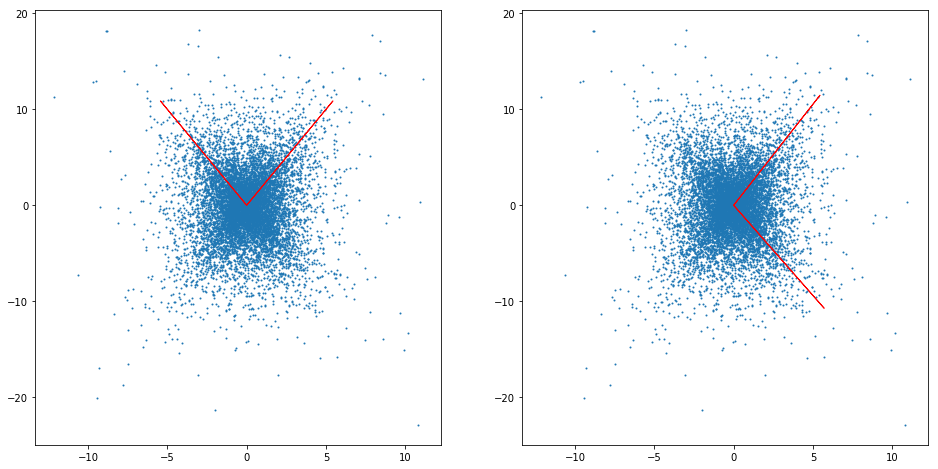

In [13]:
compareMixingMatrix(synthData, verifyA, estimateA)

## Utilize Algorithm to Separate Mixed Sound Tracks
Now that we've verified our algorithm's correctness on some dummy data, we can try to use it to separate the mixed sound tracks.

In [14]:
A, S = bss(X)

We'll need to normalize our recovered sound tracks. Then we can write them into files to listen to.

In [15]:
# normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrackA.wav', 22050, S[0])
wavfile.write('data/separatedTrackB.wav', 22050, S[1])

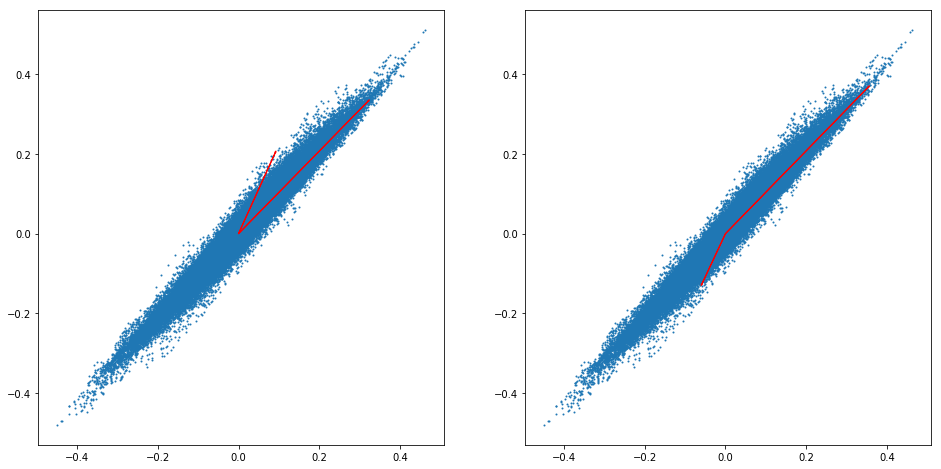

In [16]:
compareMixingMatrix(X, gtruthA, A)

If you run the notebook and listen to the separated file you can hear that they've been perfectly separated! Let's compare our optimized mixture matrix to the ground truth mixture matrix:

In [17]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Ground Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[ -1630.88733226   9859.58086908]
 [ -3524.06266528  10255.39228176]]

Mixing Matrix (Ground Truth)

 [[ 0.87160544  0.24724763]
 [ 0.90318289  0.552474  ]]


While it may be surprising that our optimized mixing matrix is so far off from the ground truth, all that matters is the preservation of the ratios between the elements of the matrix. That is extremely close in our mixing matrix compared to the ground truth.

## Mixing & Separating More Sounds
We have some more sound files so let's try mixing those and seeing how well our algorithm does separating them.

In [18]:
srate, dataBigBrain = wavfile.read('data/bigbrain.wav')
_, dataCoincidence = wavfile.read('data/coincidence.wav')

Unlike with the previous two sounds, these two aren't the same duration so we'll have to clip the longer one.

In [19]:
if dataBigBrain.shape[0] < dataCoincidence.shape[0]:
    dataCoincidence = dataCoincidence[:dataBigBrain.shape[0]]
else:
    dataBigBrain = dataBigBrain[:dataCoincidence.shape[0]]

In [20]:
gtruthS = audionorm([dataBigBrain, dataCoincidence])

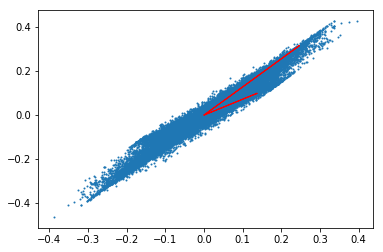

In [21]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

In [22]:
wavfile.write('data/mixedTrack_BB&C_A.wav', srate, X[0])
wavfile.write('data/mixedTrack_BB&C_B.wav', srate, X[1])

In [23]:
A, S = bss(X)

In [24]:
# normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrack_BB&C_A.wav', 22050, S[0])
wavfile.write('data/separatedTrack_BB&C_B.wav', 22050, S[1])

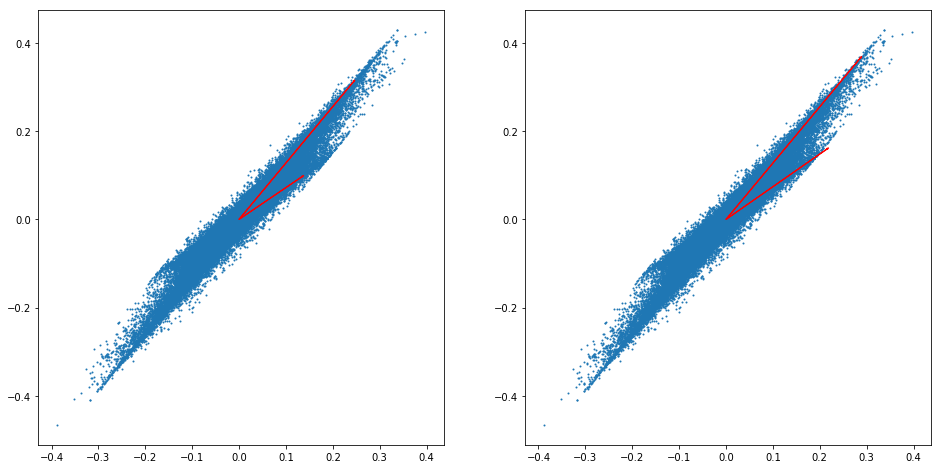

In [25]:
compareMixingMatrix(X, gtruthA, A)

In [26]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Ground Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[ 3587.82084117  4775.09500263]
 [ 2658.0209984   6098.59453956]]

Mixing Matrix (Ground Truth)

 [[ 0.66668431  0.36675565]
 [ 0.85268962  0.2643847 ]]


Yet again, our algorithm works perfectly!

## Separating a mixture of mixtures
Let's try to mix two mixtures and see if we can separate them and then separate the resulting mixtures into the original files

In [27]:
gtruthS = audionorm([X[0], X[1]])

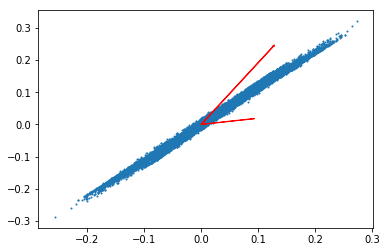

In [28]:
X, gtruthA_ = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA_)

In [30]:
A, S = bss(X)

In [31]:
A, S = bss(S)

In [32]:
# normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrack_multimix_A.wav', 22050, S[0])
wavfile.write('data/separatedTrack_multimix_B.wav', 22050, S[1])

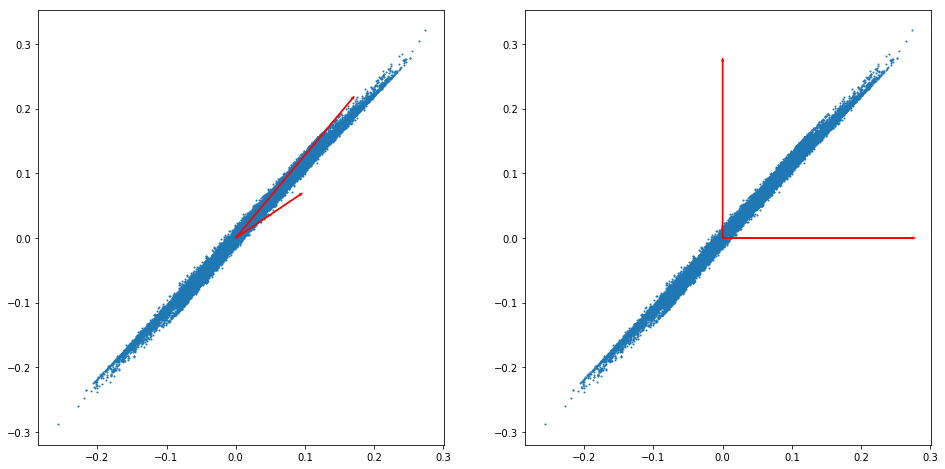

In [33]:
compareMixingMatrix(X, gtruthA, A)

In [34]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Ground Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[  1.00004219e+00   8.16012767e-05]
 [ -2.68992488e-06   1.00004216e+00]]

Mixing Matrix (Ground Truth)

 [[ 0.66668431  0.36675565]
 [ 0.85268962  0.2643847 ]]


I'm honestly kind of surprised. If you run the notebook and generate the file you'll find that it works perfectly and can obtain the original sources. I don't have the time to check the math to see why this is a valid result, but it just didn't seem like it would work.